In [21]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from tensorflow import python as tf_python
from sklearn.metrics import confusion_matrix,classification_report
import scikitplot as skplt

%matplotlib inline

In [22]:
#loads in files for signal and background
file_sig = uproot.open("mc16e_signal.root")
file_back = uproot.open("mc16e_ttbar.root")

#Sets trees of files to variables
tree_sig = file_sig["nominal"]
tree_back = file_back["nominal"]

#Prints number of entries for each tree
print(f'Signal tree entries: {tree_sig.num_entries}')
print(f'Background tree entries: {tree_back.num_entries}')

Signal tree entries: 3319
Background tree entries: 3531


In [23]:
#Shows contents of each tree
#tree_sig.show()
#tree_back.show()

In [24]:
muonStats_sig = tree_sig.arrays(['mu_pt', 'mu_eta', 'mu_phi'])
jetStats_sig = tree_sig.arrays(['jet_pt', 'jet_eta', 'jet_phi'])
muonStats_back = tree_back.arrays(['mu_pt', 'mu_eta', 'mu_phi'])
jetStats_back = tree_back.arrays(['jet_pt', 'jet_eta', 'jet_phi'])

In [25]:
print(np.concatenate(np.array(muonStats_sig['mu_pt']), axis = 0))

[109464.52   65954.625 148726.    ...  53041.37   58756.44   56119.04 ]


In [26]:
#plt.hist(np.concatenate(muonStats_sig['mu_pt'], axis = 0),bins=np.linspace(0,450000,101),label='Signal', histtype='step')
#plt.hist(np.concatenate(muonStats_back['mu_pt'], axis = 0),bins=np.linspace(0,450000,101),label='Background', histtype='step')
#plt.xlabel(r'Muon $p_{T}$ [GeV]')
#plt.ylabel('Count')
#plt.legend()
#plt.show()

In [27]:
print(tree_sig.keys(filter_name="/(ljet|mu)_(pt|eta|phi)/"))
allStats_sig = tree_sig.arrays(filter_name="/(ljet|mu)_(pt|eta|phi)/", library = 'pd')
allStats_back = tree_back.arrays(filter_name="/(ljet|mu)_(pt|eta|phi)/", library = 'pd')
muonStats_sig = allStats_sig[0];
jetStats_sig = allStats_sig[1];
muonStats_back = allStats_back[0];
jetStats_back = allStats_back[1];

print(allStats_sig);

['mu_pt', 'mu_eta', 'mu_phi', 'ljet_pt', 'ljet_eta', 'ljet_phi', 'ljet_pt_cand', 'ljet_eta_cand', 'ljet_phi_cand']
(                        mu_pt    mu_eta    mu_phi   ljet_pt_cand  \
entry subentry                                                     
0     0         109464.523438  0.752634 -0.603566  274842.875000   
1     0          65954.625000  0.954476  0.651902  212455.109375   
2     0         148726.000000  1.510869 -0.182065  371398.625000   
3     0          71516.101562  0.254257  2.440928  331628.312500   
4     0         222168.671875  0.672102  0.522216  341838.843750   
...                       ...       ...       ...            ...   
3314  0          52193.957031  0.362391  2.417538  231281.109375   
3315  0         146224.984375 -0.150667  0.455322  268928.281250   
3316  0          53041.371094 -1.209407  1.332303  219864.437500   
3317  0          58756.441406  0.259072  1.774282  221806.578125   
3318  0          56119.039062 -0.593785  1.690351  293187.750000   


In [28]:
#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, list_IDs, labelsFunc, useWeightObj = False, weightObj = 0, batch_size=32, dim=(14), n_channels=1, n_classes=2, shuffle=True):
        self.dim = dim
        self.useWeightObj = useWeightObj
        self.weightObj = weightObj
        self.batch_size = batch_size
        self.labelsFunc = labelsFunc
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X[:, :-1], y, (X[:, -1])

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, self.dim,))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i] = np.load('data/' + str(ID) + '.npy')

            # Store class
            y[i] = self.labelsFunc(ID)
        
        X[:, :-1] = StandardScaler().fit_transform(X[:, :-1])

        if(self.useWeightObj):
            X[:, -1] = X[:, -1] * [self.weightObj[i] for i in y]

        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
def getList_ID(fileName, tree, varNames, max_entry = 10000):
    df = pd.DataFrame()
    opFile = uproot.open(fileName + ':' + tree)
    for var in varNames:
        varDf = opFile[var].array(entry_stop = max_entry, library = 'pd')
        if(varDf.index.nlevels == 2):
            df[var] = varDf.reset_index(level=1, drop=True)
        else:
            df[var] = varDf
    df.filter(df['weight'] > 0)
    saveArr = df.to_numpy()
    savePrefix = fileName[:fileName.find('.')]
    saveStrings = []
    for i in range(saveArr.shape[0]):
        saveString = savePrefix + str(i)
        saveStrings.append(saveString)
        np.save('data/' + saveString + '.npy', saveArr[i])
    return saveStrings

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, inputShape, bias):
    model = keras.Sequential([
        keras.layers.Dense(4, activation='relu', input_shape=inputShape, bias_initializer=keras.initializers.Constant(bias)),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(32, activation='relu'),
        # keras.layers.Dense(8, activation='relu'),
        #keras.layers.Dense(4, activation='relu'),
        #tf.keras.layers.Dense(units=2, activation='softmax')
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model

def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    print("key: " + key)
    for var in train_variables:
        if var == "classification":
            continue
        else:
            print("var: " + var)
            print(dict[key])
            print(dict[key][var])
            print(np.array(dict[key][var].array(library = 'pd')))
            #df[var] = np.array(dict[key][var].array())
    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

In [29]:
def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    print("key: " + key)
    for i in range(len(train_variables)):
        var = train_variables[i];
        if(var == 'classification'):
            continue
        else:
            df.insert(len(df.columns), var, dict[key][var].array(library = 'pd'))

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

key: signal_e
SIGNAL CLASSIFICATION SET TO 1 signal_e


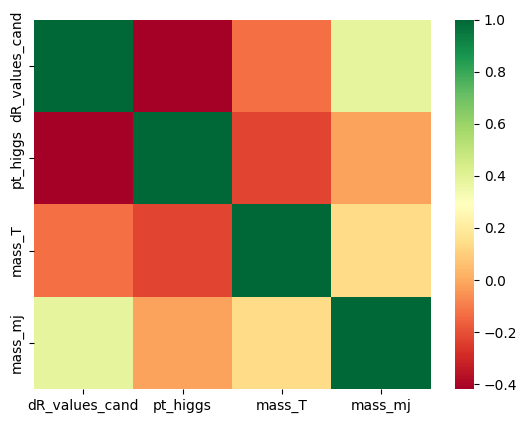

In [30]:
#train_variables = ['mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

train_variables = ['classification','dR_values_cand','pt_higgs','mass_T', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(train_variables, {"signal_e" : tree_sig})

In [31]:
max_entries = 10000

train_variables = ['mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signalMatrix = getList_ID('mc16e_signal.root', 'nominal', train_variables, max_entry = max_entries)
signalLabels = np.ones(shape = len(signalMatrix))

ttbarMatrix = getList_ID('mc16e_ttbar.root', 'nominal', train_variables, max_entry = max_entries)
ttbarLabels = np.zeros(shape = len(ttbarMatrix))

mixedMatrix = np.concatenate((signalMatrix, ttbarMatrix))
mixedLabels = np.concatenate((signalLabels, ttbarLabels))

trainMatrix1, valMatrix, trainLabels1, valLabels = train_test_split(mixedMatrix, mixedLabels, test_size = 0.1)
trainMatrix, testMatrix, trainLabels, testLabels = train_test_split(trainMatrix1, trainLabels1, test_size = 0.1)

numSig = len(signalMatrix)
numBack = len(ttbarMatrix)
totalEntries = numSig + numBack
bias = numSig / (totalEntries)
class_weight = {0: totalEntries/(2*numBack), 1: totalEntries/(2*numSig)}

In [32]:
print(trainMatrix.__getitem__(1))
print(trainMatrix[0])
#print(trainLabels)
#print(testMatrix)
#print(testLabels)

mc16e_signal2625
mc16e_signal2375


In [33]:
def getLabel(ID):
    if("mc16e_signal" in ID):
        return 1
    elif("mc16e_ttbar" in ID):
        return 0

trainGenerator = DataGenerator(mixedMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=256, dim=14, n_channels=1, n_classes=2, shuffle=True)

valGenerator = DataGenerator(valMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=256, dim=14, n_channels=1, n_classes=2, shuffle=True)

testGenerator = DataGenerator(testMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=256, dim=14, n_channels=1, n_classes=2, shuffle=True)

In [34]:
print(trainGenerator[0])
print(trainGenerator[0][0])
print(trainGenerator[0][1])
print(trainGenerator[0][2])



(array([[ 1.71191491, -1.33080344, -1.54720405, ...,  1.46869655,
        -1.41633862,  0.24643954],
       [-0.15393907,  1.34855147,  1.46653672, ...,  0.4134363 ,
        -1.6501906 , -1.06153034],
       [-0.79585039, -0.48221681,  0.22366738, ...,  0.11174436,
        -0.28008785,  0.39952099],
       ...,
       [-0.16902344,  0.88164584,  0.01270946, ...,  0.26348539,
        -0.14371319, -0.41589282],
       [-0.30803758,  2.10987734, -0.73907771, ...,  1.51598418,
        -0.13701495, -0.36915139],
       [ 0.09777169,  0.92210592,  1.22192682, ..., -0.96548007,
         1.51773151,  1.03452487]]), array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32), array([0.00432557, 0.00756403, 0.10269706, ..., 0.09471179, 0.067259  ,
       0.00787717]))
[[ 1.71191491 -1.33080344 -1.54720405 ...  1.46869655 -1.41633862
   0.24643954]
 [-0.15393907  1.34855147  1.46653672 ...  0.4134363  -1.6501906
  -1.06153034]


In [35]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]

nn_model = get_model(METRICS, (13,), bias)
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                280       
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


In [36]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)

nnfit = nn_model.fit(trainGenerator, epochs = 1000, callbacks=[early_stopping, cp_callback])

#y_scores = nn_model.predict(scaled_test_df)
nn_model.save('sample_model.h5')

Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 0.0403 - tp: 2616.0000 - fp: 3451.0000 - tn: 2549.0000 - fn: 3384.0000 - accuracy: 0.4304 - precision: 0.4312 - recall: 0.4360 - auc: 0.3942 - prc: 0.4176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc

Epoch 1: saving model to checkpoint.ckpt
3/3 [==============================] - 5s 677ms/step - loss: 0.0403 - tp: 2616.0000 - fp: 3451.0000 - tn: 2549.0000 - fn: 3384.0000 - accuracy: 0.4304 - precision: 0.4312 - recall: 0.4360 - auc: 0.3942 - prc: 0.4176
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.0400 - tp: 2637.0000 - fp: 3428.0000 - tn: 2572.0000 - fn: 3363.0000 - accuracy: 0.4341 - precision: 0.4348 - recall: 0.4395 - auc: 0.3973 - prc: 0.4192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,tp,fp,tn,fn,ac

KeyboardInterrupt: 

In [ ]:
def hiWeightVars(model, inVars):
    model_weights = model.layers[0].get_weights()[0]
    if('classification' in inVars):
        inVars.remove('classification')
    if('weight' in inVars):
        inVars.remove('weight')
    model_weights = [np.mean([abs(weight) for weight in weights]) for weights in model_weights]
    
    a = zip(model_weights, inVars)
    b = sorted(a)
    model_weights, inVars = zip(*b)

    for i in range(len(model_weights)):
        print(str(inVars[i]) + ": " + str(model_weights[i]))

hiWeightVars(nn_model, train_variables)



mueta_cand: 0.16002351
muphi_cand: 0.18046325
ljet_pt_cand: 0.19509485
met_phi: 0.21438567
mass_mj: 0.28379577
mupt_cand: 0.29799345
ljet_phi_cand: 0.30252308
mass_T: 0.31369695
ljet_eta_cand: 0.35461175
dR_values_cand: 0.3590666
pt_higgs: 0.3704209
ljet_mass_cand: 0.37326616
met_met: 0.401074


In [ ]:
probability_model = tf.keras.Sequential([nn_model, tf.keras.layers.Softmax()])
predictions = nn_model.predict(testGenerator[0][0])
print(predictions)

8/8 [==============================] - 0s 2ms/step
[[0.50128454 0.4963157 ]
 [0.97932845 0.9771987 ]
 [0.8643316  0.7468014 ]
 [0.91545    0.6924078 ]
 [0.8394927  0.687058  ]
 [0.83755374 0.5175192 ]
 [0.640758   0.6465434 ]
 [0.90286225 0.6040088 ]
 [0.87116736 0.5244425 ]
 [0.9325398  0.57892627]
 [0.6024543  0.46521288]
 [0.76312405 0.71444637]
 [0.85875124 0.8177056 ]
 [0.71272844 0.70370287]
 [0.8300963  0.53513   ]
 [0.787357   0.38734102]
 [0.88638246 0.6541037 ]
 [0.63799673 0.47185093]
 [0.53652894 0.5339829 ]
 [0.8579109  0.42137048]
 [0.52639204 0.5184237 ]
 [0.76835924 0.52304804]
 [0.8577261  0.8710656 ]
 [0.78026605 0.75332105]
 [0.7701825  0.7484358 ]
 [0.816429   0.5475472 ]
 [0.50128454 0.4963157 ]
 [0.8160762  0.59829277]
 [0.79660636 0.76533294]
 [0.50128454 0.4963157 ]
 [0.8438023  0.83609354]
 [0.89019257 0.7804105 ]
 [0.7575612  0.59437925]
 [0.7380238  0.47398674]
 [0.86866474 0.67824876]
 [0.82038105 0.6802491 ]
 [0.6259334  0.45129293]
 [0.8167648  0.544914  ]

In [ ]:
#nn_model = get_model((14,))
# #fit the model to train on all but the last column
#print("MATT, FITTING MODEL")
#callback = LearningRateScheduler(custom_LearningRate_schedular)
# print(train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]])
#nn_fit = nn_model.fit(train_dataset[:, 0:train_dataset.shape[1]-1], train_output, epochs=500, batch_size = 500, validation_data=(val_dataset[:, 0:train_dataset.shape[1]-1], val_output), sample_weight=train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]], shuffle=True)
# validation_data=(val_dataset[:, 0:train_dataset.shape[1]-1], val_output),
# print(train_dataset[:,0:train_dataset.shape[1]-1])
# nn_fit = nn_model.fit(train_dataset[:,0:train_dataset.shape[1]-1], train_output[:,0:0:train_dataset.shape[1]-1], epochs=70, batch_size=500, verbose=1, shuffle=True, validation_data=(val_dataset[:,0:train_dataset.shape[1]-1], val_output[:,0:train_dataset.shape[1]-1]), sample_weight=train_dataset[:,train_dataset.shape[1]-1:train_dataset.shape[1]])
#print("MATT, MODEL FITTED")
#print("MATT, PREDICTING")
#y_scores = nn_model.predict(test_dataset[:, 0:train_dataset.shape[1]-1])



#bdt_model = boosted_decision_tree()
#print("MATT, FITTING MODEL")
#bdt_fit = bdt_model.fit(train_dataset[:, 0:train_dataset.shape[1]-1], train_output, sample_weight=train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]])
#print("MATT, MODEL FITTED")
#print("MATT, PREDICTING")
#bdt_y_scores = bdt_model.predict(test_dataset[:, 0:train_dataset.shape[1]-1])


In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class CIFAR10Sequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

In [ ]:
genObj = CIFAR10Sequence([1, 2, 3, 4, 5], [1, 4, 9, 16, 25], 2)

In [ ]:
testingModel = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(62, activation='softmax')
])

